Eye Disease Classification Pipeline


In [61]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random


In [62]:
# Define paths for raw and processed data
raw_data_dir = Path("../data/raw")
processed_data_dir = Path("../data/processed")

# Create processed directory structure if it doesn't exist
processed_data_dir.mkdir(parents=True, exist_ok=True)


In [63]:
# Load images by category
image_paths = {category.name: list(category.glob("*.jpg")) + 
               list(category.glob("*.jpeg")) + 
               list(category.glob("*.png"))
               for category in raw_data_dir.iterdir() if category.is_dir()}

print("Categories found:", image_paths.keys())

Categories found: dict_keys(['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal'])


In [86]:
# Preprocessing functions

def histogram_equalization(image):
    # Check if the image is in grayscale; if not, convert it to grayscale
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Apply histogram equalization
    equalized_image = cv2.equalizeHist(gray_image)

    return equalized_image
    
def denoise_image(image):
    
    # Check if the image is in grayscale; if not, convert it to grayscale
    if len(image.shape) == 3:
        # Denoise color image
        denoised_image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    else:
        # Denoise grayscale image
        denoised_image = cv2.fastNlMeansDenoising(image, None, 10, 7, 21)

    return denoised_image

def adjust_brightness_contrast(image, alpha=1.0, beta=0):

    # Check if the image is in grayscale; if not, adjust brightness and contrast for color
    adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    
    return adjusted_image

def preprocess_for_filters(image):
    # Step 1: Enhance contrast
    image = histogram_equalization(image)
    
    # Step 2: Denoise the image
    image = denoise_image(image)
    
    # Step 3: Adjust brightness and contrast
    image = adjust_brightness_contrast(image)
    
    return image


def normalize_image(image):
    # Normalize to range [0, 255] and convert to 8-bit format for compatibility
    normalized = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    return normalized.astype(np.uint8)

    
def resize_image(image, size=(256, 256)):
    # Resize the image to the specified size (256x256 by default)
    resized_image = cv2.resize(image, size)
    return resized_image


def laplacian_filter(image):
   # Apply Laplacian filter
    laplacian = cv2.Laplacian(image, cv2.CV_64F)

    # Convert to 8-bit image
    laplacian_abs = cv2.convertScaleAbs(laplacian)

    # Blend the original with the Laplacian
    blended = cv2.addWeighted(image, 0.8, laplacian_abs, 0.2, 0)  # Adjust weights as needed
    return blended


def apply_averaging_filter(image, kernel_size=5):
    
    # Apply the averaging filter
    blurred_image = cv2.blur(image, (kernel_size, kernel_size))

    return blurred_image


def convert_to_grayscale_opencv(image):

    # Convert to grayscale
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    return grayscale_image

def canny_edge_detection(image, low_threshold=100, high_threshold=200):
   
    # Check if the image is in grayscale; if not, convert it to grayscale
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Apply Gaussian Blur to reduce noise and improve edge detection
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 1.5)

    # Perform Canny edge detection
    edges = cv2.Canny(blurred_image, low_threshold, high_threshold)

    return edges

def merge_edges_with_image(original_image, edges):
    # Create a color version of the edges
    color_edges = np.zeros_like(original_image)  # Initialize a color image
    color_edges[edges > 0] = [0, 0, 255]  # Red color for edges

    # Merge the original image with the edge image
    merged_image = cv2.addWeighted(original_image, 1.0, color_edges, 0.5, 0)

    return merged_image

In [91]:
def preprocess_and_save_images():
    """Preprocess images by reducing noise, enhancing, segmenting, and normalizing, then save them."""
    for category, paths in image_paths.items():
        (processed_data_dir / category).mkdir(parents=True, exist_ok=True)
        
        for img_path in paths:
            image = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
            if image is None:
                print(f"Warning: Could not read {img_path}")
                continue

            resized_image = resize_image(image)
            prepare_image = preprocess_for_filters(resized_image)
            normal_image = normalize_image(prepare_image)
            blurred_image = apply_averaging_filter(normal_image)
            #laplacian_image = laplacian_filter(blurred_image)
            edge_image = canny_edge_detection(blurred_image)
            merged_image = merge_edges_with_image(resized_image, edge_image)
           

            

            # Save the processed image
            output_filename = img_path.stem + "_processed.jpg"  # Change to .jpg
            output_path = processed_data_dir / category / output_filename
            
            cv2.imwrite(str(output_path), merged_image)
            print(f"Processed and saved: {output_path}")


In [ ]:
# Run the process
preprocess_and_save_images()
print("Saved the processed images")

In [93]:
def display_sample_images(num_samples=5):
    """Display sample images from the processed dataset."""
    categories = list(image_paths.keys())
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    
    for ax in axes:
        category = random.choice(categories)
        sample_image_path = random.choice(list((processed_data_dir / category).glob("*_processed.jpg")))
        sample_image = cv2.imread(str(sample_image_path))
        ax.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
        ax.axis('off')
        ax.set_title(category)
    
    plt.show()

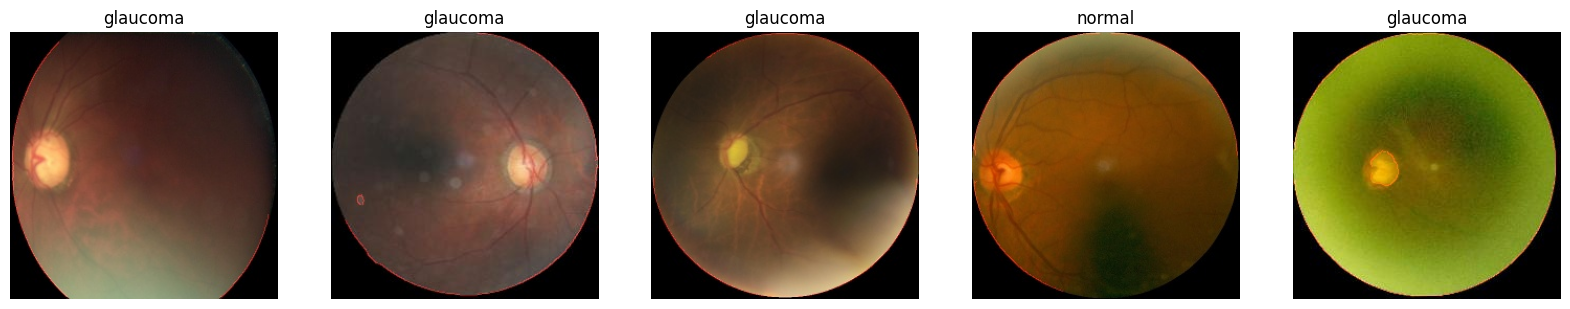

In [94]:
# Display sample images
display_sample_images(num_samples=5)